In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler

train_data = pd.read_csv("daan881_group4_dataset.train.csv")
val_data = pd.read_csv("daan881_group4_dataset.val.csv")

train_data.head()

,cve,attack_vector,attack_complexity,attack_requirements,privileges_required,user_interaction,exploit_maturity,epss,percentile,cvss_score,cvss_severity,days_since_reserved,days_since_published,date_reserved_published_delta,priority_score,group_id
0,CVE-2021-22205,1.0,0.0,NaN,2.0,0.0,NaN,0.97358,0.99922,10.0,1.0,1411,1302,109,64.176359,1
1,CVE-2021-27964,NaN,NaN,NaN,NaN,NaN,NaN,0.69570,0.98057,NaN,NaN,1352,1352,0,59.109850,1
2,CVE-2023-33568,NaN,NaN,NaN,NaN,NaN,NaN,0.52799,0.97628,NaN,NaN,544,522,22,27.574869,1
3,CVE-2021-39014,1.0,0.0,NaN,0.0,0.0,NaN,0.00050,0.19731,6.4,3.0,1187,497,690,14.075887,1
4,CVE-2022-26843,1.0,1.0,NaN,2.0,1.0,NaN,0.00201,0.58105,8.3,2.0,982,638,344,13.170296,1


In [74]:
features = [
    "attack_vector",
    "attack_complexity",
    "attack_requirements",
    "privileges_required",
    "user_interaction",
    "exploit_maturity",
    "epss",
    "percentile",
    "cvss_score",
    "cvss_severity",
    "days_since_published",
    "date_reserved_published_delta"
]
X = train_data[features]
y = train_data["priority_score"]
groups = train_data["group_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train = groups.iloc[train_idx]
    groups_test = groups.iloc[test_idx]

# Verify group integrity
print("Train Groups:", groups_train.unique())
print("Test Groups:", groups_test.unique())

Train Groups: [   1    2    3    4    5    6    7    8    9   10   12   13   14   15
   16   17   18   19   20   21   22   23   25   27   28   29   30   32
   33   34   35   36   37   38   39   41   42   43   44   46   47   48
   49   50   51   52   53   54   57   58   59   62   63   65   66   69
   70   72   74   75   76   78   80   81   82   83   84   85   86   88
   90   91   92   93   94   95   96   98   99  100  101  103  104  105
  106  107  109  110  112  113  114  115  116  117  118  119  120  122
  123  124  125  126  127  128  129  130  131  132  133  134  135  136
  139  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  160  161  162  163  164  165  166  167  168
  170  171  172  173  174  176  177  178  179  180  181  182  183  184
  186  187  188  189  190  191  192  193  194  195  196  197  198  201
  202  203  204  205  206  207  208  212  213  215  217  218  220  221
  223  224  225  226  227  228  229  230  231  232  233  234  2

In [75]:
# Calculate group sizes for training and testing
train_group_sizes = groups_train.value_counts(sort=False).values
test_group_sizes = groups_test.value_counts(sort=False).values

scaler = MinMaxScaler(feature_range=(0, 31))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten().astype(int)
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten().astype(int)

# Create DMatrix for XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train_scaled)
test_dmatrix = xgb.DMatrix(X_test, label=y_test_scaled)

# Set group sizes
train_dmatrix.set_group(train_group_sizes)
test_dmatrix.set_group(test_group_sizes)

# Define XGBoost parameters
params = {
    "objective": "rank:pairwise",  # Pairwise ranking
    "eval_metric": "ndcg",        # Normalized Discounted Cumulative Gain
    "learning_rate": 0.1,
    "max_depth": 6,
    "n_estimators": 100,
    "random_state": 42
}

evals_result = {}

# Train the model
ranker = xgb.train(
    params,
    train_dmatrix,
    num_boost_round=100,
    evals=[(train_dmatrix, "train"), (test_dmatrix, "test")],
    verbose_eval=10,
    evals_result=evals_result
)

[0]	train-ndcg:0.83582	test-ndcg:0.82741


/home/clayton/workspace/daan881/daan881/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:44:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-ndcg:0.87646	test-ndcg:0.86583
[20]	train-ndcg:0.89488	test-ndcg:0.89392
[30]	train-ndcg:0.91248	test-ndcg:0.90918
[40]	train-ndcg:0.91761	test-ndcg:0.92543
[50]	train-ndcg:0.92824	test-ndcg:0.92794
[60]	train-ndcg:0.93353	test-ndcg:0.93085
[70]	train-ndcg:0.93618	test-ndcg:0.93568
[80]	train-ndcg:0.93852	test-ndcg:0.93676
[90]	train-ndcg:0.94035	test-ndcg:0.93939
[99]	train-ndcg:0.94196	test-ndcg:0.94187


In [76]:
# Predict rankings for test data
y_pred = ranker.predict(test_dmatrix)

# Evaluate using NDCG score
ndcg = ndcg_score([y_test], [y_pred])
print("NDCG Score:", ndcg)

# Rank the CVEs in the test set based on predictions
X_test['predicted_priority'] = y_pred
X_test['true_priority'] = y_test
ranked_cves = X_test.sort_values(by='predicted_priority', ascending=False)

# Output ranked CVEs
print(ranked_cves)

NDCG Score: 0.9980916651507575
        attack_vector  attack_complexity  attack_requirements  \
168434            1.0                0.0                  NaN   
289137            1.0                0.0                  NaN   
25565             1.0                0.0                  NaN   
144722            1.0                0.0                  NaN   
76484             NaN                NaN                  NaN   
...               ...                ...                  ...   
187400            NaN                NaN                  NaN   
187417            NaN                NaN                  NaN   
187455            NaN                NaN                  NaN   
187491            NaN                NaN                  NaN   
187515            NaN                NaN                  NaN   

        privileges_required  user_interaction  exploit_maturity     epss  \
168434                  2.0               1.0               NaN  0.80818   
289137                  2.0         

/tmp/ipykernel_125486/292277252.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predicted_priority'] = y_pred
/tmp/ipykernel_125486/292277252.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['true_priority'] = y_test


In [77]:
# Evaluate NDCG for training and test sets
train_predictions = ranker.predict(train_dmatrix)
test_predictions = ranker.predict(test_dmatrix)

train_ndcg = ndcg_score([y_train_scaled], [train_predictions])
test_ndcg = ndcg_score([y_test_scaled], [test_predictions])

print(f"Train NDCG: {train_ndcg}")
print(f"Test NDCG: {test_ndcg}")

Train NDCG: 0.997506717877521
Test NDCG: 0.9968253934710054


In [78]:
def mean_reciprocal_rank(y_true, y_pred, groups):
    """
    Calculate Mean Reciprocal Rank (MRR) for grouped data.
    
    Parameters:
    - y_true: Array of true relevance scores for all items.
    - y_pred: Array of predicted scores for all items.
    - groups: List of group sizes (number of items in each group).

    Returns:
    - MRR: Mean Reciprocal Rank score.
    """
    mrr = []
    start = 0

    for group_size in groups:
        # Slice the true and predicted values for the current group
        end = start + group_size
        true_group = y_true[start:end]
        pred_group = y_pred[start:end]

        # Get the sorted indices of predictions for the group
        sorted_indices = np.argsort(-pred_group)

        # Find the rank of the most relevant item
        for rank, idx in enumerate(sorted_indices, start=1):
            if true_group[idx] == max(true_group):  # Check for the most relevant item
                mrr.append(1 / rank)
                break

        start = end  # Move to the next group

    # Return the mean of reciprocal ranks across all groups
    return np.mean(mrr)

test_group_sizes = groups_test.value_counts(sort=False).tolist()

scaler = MinMaxScaler(feature_range=(0, 31))
test_predictions = scaler.fit_transform(test_predictions.reshape(-1, 1)).flatten().astype(int)

# Compute MRR for test set
test_mrr = mean_reciprocal_rank(y_test_scaled, test_predictions,test_group_sizes)
print(f"Test MRR: {test_mrr}")

Test MRR: 0.9303414502164503


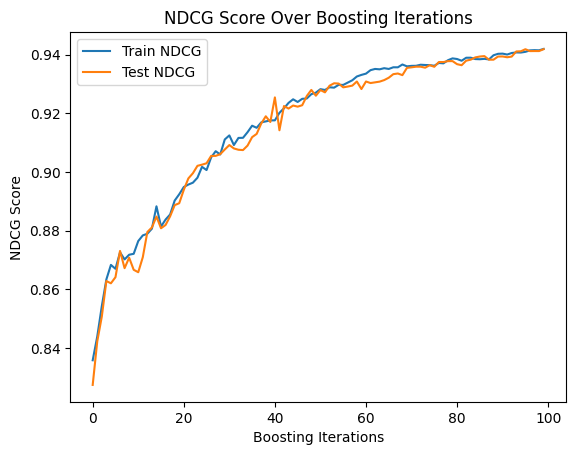

In [79]:
# Plot NDCG over iterations
import matplotlib.pyplot as plt

plt.plot(evals_result['train']['ndcg'], label="Train NDCG")
plt.plot(evals_result['test']['ndcg'], label="Test NDCG")
plt.xlabel("Boosting Iterations")
plt.ylabel("NDCG Score")
plt.title("NDCG Score Over Boosting Iterations")
plt.legend()
plt.show()

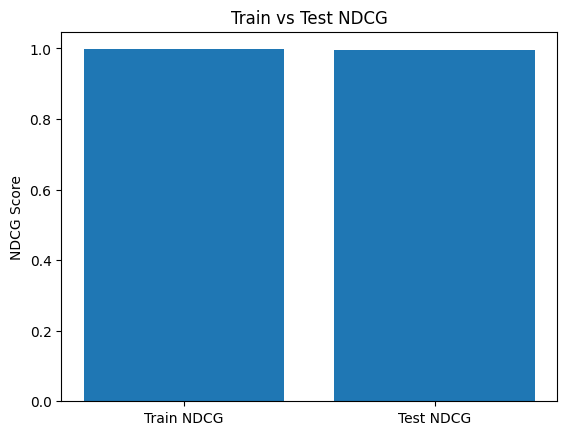

In [80]:
# Example: Comparing train and test NDCG scores
metrics = {"Train NDCG": train_ndcg, "Test NDCG": test_ndcg}

# Bar plot
plt.bar(metrics.keys(), metrics.values())
plt.ylabel("NDCG Score")
plt.title("Train vs Test NDCG")
plt.show()

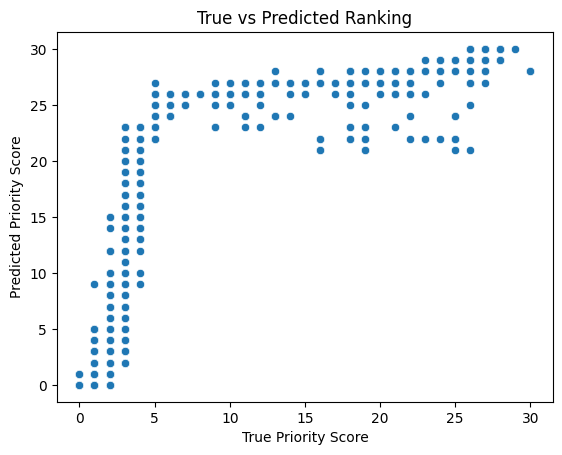

In [81]:
# Predicted vs True ranking (Test Set)
import seaborn as sns

results = pd.DataFrame({
    'True Score': y_test_scaled,
    'Predicted Score': test_predictions
})

sns.scatterplot(x='True Score', y='Predicted Score', data=results)
plt.title("True vs Predicted Ranking")
plt.xlabel("True Priority Score")
plt.ylabel("Predicted Priority Score")
plt.show()